# Analysis of NFL play choice: tendencies & play call prediction

## import packages that will be used

In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

##for random grid search, done once
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score
from sklearn.model_selection import KFold

In [255]:
#display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## read in data & view

In [256]:
df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")

C:\Users\pspat\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [257]:
df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackl

## Data cleaning

In [258]:
#filter to non-special teams related plays or timeouts
df=df.loc[(df['play_type'] == 'pass')|(df['play_type'] == 'run')]
df=df.loc[df["two_point_attempt"] == 0]
df=df.loc[df["timeout"] == 0] 
df=df.loc[df["extra_point_attempt"] == 0] 
df=df.loc[df["ydstogo"] > 0] 
df=df.loc[df["penalty"] == 0] 

In [259]:
#clean up issues with team names
df.loc[df['posteam']=='JAC','posteam']='JAX'
df.loc[df['posteam']=='STL','posteam']='LAR'
df.loc[df['posteam']=='LA','posteam']='LAR'
df.loc[df['posteam']=='SD','posteam']='LAC'

#convert down from float to int
df_play_choice['down']=df_play_choice['down'].astype(int)

## Subset the dataframe to columns of interest for current analysis

In [260]:
df_play_choice = df[['game_date','yardline_100', 'half_seconds_remaining','game_seconds_remaining','down','ydstogo','play_type','yards_gained','posteam','shotgun','score_differential','desc']]

In [261]:
#check missing values and treat--in this case dropped due to low fraction of missing data
df_play_choice.isna().sum()

game_date                   0
yardline_100                0
half_seconds_remaining     17
game_seconds_remaining     14
down                        0
ydstogo                     0
play_type                   0
yards_gained              207
posteam                     0
shotgun                     0
score_differential          0
desc                        0
dtype: int64

In [262]:
df_play_choice.dropna(inplace=True)

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [263]:
## add column for year--for purposes of analysis downstream
df_play_choice['year'] = df_play_choice['game_date'].apply(lambda x:x[:4])

## create new column for encoded play_type and posteam for model downstream
df_play_choice['play_type_encoded'] = df_play_choice['play_type'].apply(lambda x: 0 if x == 'run' else 1)
le = LabelEncoder()
df_play_choice['posteam_encoded'] = le.fit_transform(df_play_choice['posteam'])

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

## Tendency Analysis (2008-2018 NFL Data)

### Start with comparing broadly pass vs run play calling tendencies

Pass vs Run across the league

Text(0, 0.5, 'Occurrences')

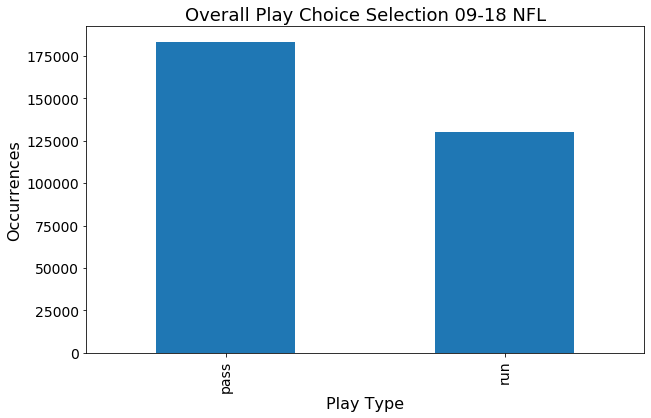

In [264]:
fig1=df_play_choice['play_type'].value_counts().plot(kind='bar', figsize = (10,6), fontsize=14)
plt.title('Overall Play Choice Selection 09-18 NFL', fontsize = 18)
plt.xlabel('Play Type',fontsize =16)
plt.ylabel('Occurrences', fontsize = 16)

Pass vs Run by down across the league

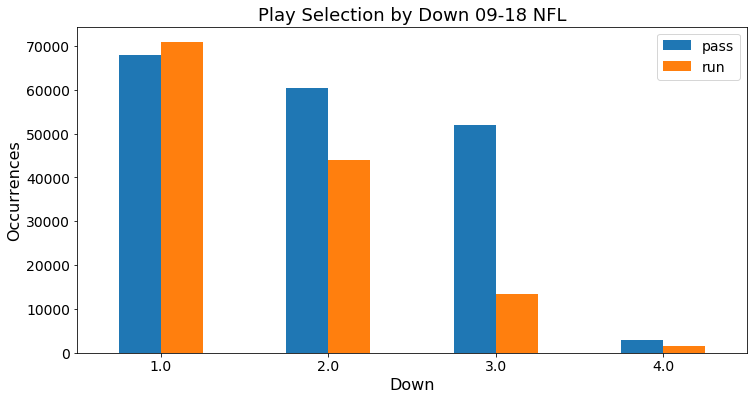

In [265]:
df_play_choice.groupby('down')['play_type'].value_counts().unstack(level=-1).plot(kind='bar',figsize=(12,6), fontsize= 14, rot = 0)
plt.xlabel('Down', fontsize=16)
plt.ylabel('Occurrences',fontsize = 16)
plt.title('Play Selection by Down 09-18 NFL', fontsize = 18)
plt.legend(fontsize = 14)

Pass vs Run by down and yards to go across the league

In [266]:
##Function to place an instance (play call) into a yards to go category
def ydstogo_grouping(row):
    if row['ydstogo'] in range(7,11):
        val = 3
    elif row['ydstogo'] in range(4,7):
        val = 2
    elif row['ydstogo'] in range(1,4):
        val = 1
    elif (row['ydstogo'] > 10) & (row['ydstogo'] < 20):
        val = 4 
    else:
        val = 5
    
    return val

In [267]:
#apply function on dataframe
df_play_choice['yds_to_go_grp'] = df_play_choice.apply(ydstogo_grouping, axis=1)

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.4, 0.45, 'Example for x-axis (2,3) represents 2nd down and yrd group 3,\n meaning 7-10 yards to go')

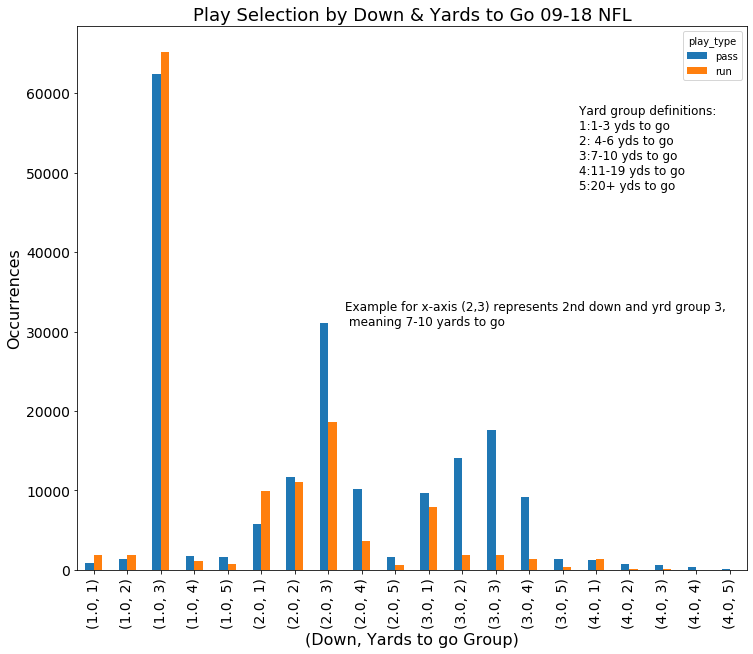

In [268]:
#generate plot
ax = df_play_choice.groupby(['down','yds_to_go_grp'])['play_type'].value_counts().unstack(level=-1).plot(kind='bar',figsize=(12,10),fontsize= 14, rot = 90)
plt.xlabel('(Down, Yards to go Group)', fontsize=16)
plt.ylabel('Occurrences', fontsize = 16)
plt.title('Play Selection by Down & Yards to Go 09-18 NFL', fontsize = 18)
plt.text(0.75,0.7,'Yard group definitions: \n1:1-3 yds to go\n2: 4-6 yds to go\n3:7-10 yds to go\n4:11-19 yds to go\n5:20+ yds to go',size = 12,transform=ax.transAxes)
plt.text(0.4,0.45,'Example for x-axis (2,3) represents 2nd down and yrd group 3,\n meaning 7-10 yards to go',size = 12,transform=ax.transAxes)

In [269]:
#tabulate results for better readability
yards_to_go_df = df_play_choice.groupby(['down','yds_to_go_grp'])['play_type'].value_counts().unstack(level=-1)
yards_to_go_df['pass_call_percent'] = round(100*(yards_to_go_df['pass']/(yards_to_go_df['pass']+yards_to_go_df['run'])),ndigits=2)
yards_to_go_df['run_call_percent'] = round(100*(yards_to_go_df['run']/(yards_to_go_df['pass']+yards_to_go_df['run'])),ndigits=2)

yards_to_go_df = yards_to_go_df.reset_index()
yards_to_go_df.columns.name = None
yards_to_go_df['yds_to_go_text']=test2['yds_to_go_grp'].apply(lambda x:'1-3' if x == 1 else('4-6' if x == 2 else('7-10' if x == 3 else('11-19' if x ==4 else '20+'))))

table_df =yards_to_go_df[['down','yds_to_go_text','pass_call_percent','run_call_percent']]
table_df=yards_to_go_df.set_index(['down','yds_to_go_text'])

table_df[['pass_call_percent','run_call_percent']]

pass_call_percent  run_call_percent
down yds_to_go_text                                     
1.0  1-3                         30.52             69.48
     4-6                         41.18             58.82
     7-10                        48.94             51.06
     11-19                       59.79             40.21
     20+                         69.30             30.70
2.0  1-3                         36.87             63.13
     4-6                         51.36             48.64
     7-10                        62.50             37.50
     11-19                       73.80             26.20
     20+                         73.81             26.19
3.0  1-3                         55.27             44.73
     4-6                         87.86             12.14
     7-10                        90.19              9.81
     11-19                       86.60             13.40
     20+                         78.42             21.58
4.0  1-3                         46.01             53.99
     4-6                         87.47             12.53
     7-10                        89.24             10.76
     11-19                       91.11              8.89
     20+                         90.53              9.47

Average yards gained by play type

In [270]:
df_play_choice.groupby('play_type').mean()['yards_gained']

play_type
pass    6.269083
run     4.336421
Name: yards_gained, dtype: float64

### Analysis of play selection through time

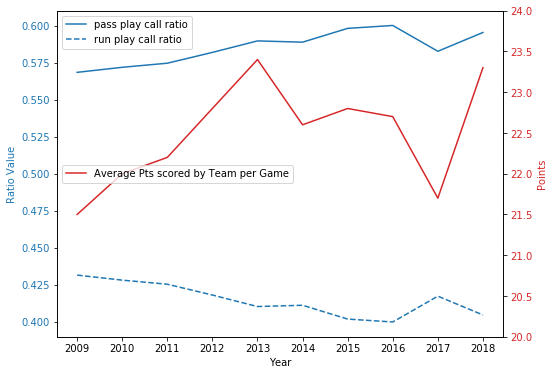

In [271]:
#group by year and calculate ratios
time_df = df_play_choice.groupby(['year','play_type_encoded']).count()['down']
time_df = time_df.unstack(level=-1)
time_df['pass_ratio']= time_df[1]/(time_df[1]+time_df[0])
time_df['run_ratio']= time_df[0]/(time_df[1]+time_df[0])

#load in scoring data to overlay
df_yearly_scoring = pd.read_csv('yearly_scoring_nfl.csv')
df_yearly_scoring.drop(index = 0, inplace = True)
df_yearly_scoring.set_index('Year', inplace=True)
df_yearly_scoring.sort_index(inplace=True)
scoring_series = df_yearly_scoring['Avg Pts per Team']
scoring_series = list(scoring_series)
time_df['avg_pts_per_team'] = scoring_series

#plot
fig, ax1 = plt.subplots(figsize=(8, 6))
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Ratio Value', color=color)
ax1.plot(time_df.index,time_df['pass_ratio'],color = color, label= 'pass play call ratio')
ax1.plot(time_df.index,time_df['run_ratio'], color = color, linestyle = 'dashed', label='run play call ratio')
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Points', color=color)
ax2.plot(time_df.index,time_df['avg_pts_per_team'], color=color,label= 'Average Pts scored by Team per Game')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([20,24])

ax1.legend(loc='best')
ax2.legend(loc='center left')

### Analysis of play direction

In [272]:
df_play_choice['direction'] = ['right' if 'right' in ele else 'left' if 'left' in ele else 'middle' if 'middle' in ele else 'other' for ele in df_play_choice['desc']]
df_play_dir = df_play_choice[df_play_choice['direction'] != 'other']

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


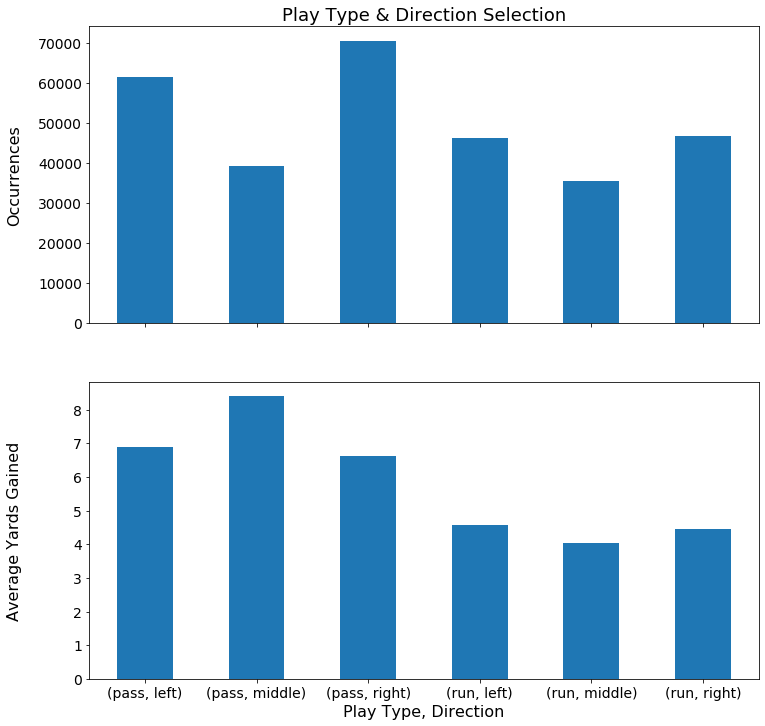

In [273]:
fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=True,figsize=(12,12))

df_play_dir.groupby(['play_type','direction'])['yards_gained'].count().plot(kind='bar', fontsize= 14, rot = 0, ax=axes[0])

axes[0].set_ylabel('Occurrences',fontsize = 16)
axes[0].set_title('Play Type & Direction Selection', fontsize = 18)

df_play_dir.groupby(['play_type','direction'])['yards_gained'].mean().plot(kind='bar', fontsize= 14, rot = 0, ax=axes[1])
axes[1].set_ylabel('Average Yards Gained',fontsize = 16)
axes[1].set_xlabel('Play Type, Direction', fontsize=16)

axes[0].get_yaxis().set_label_coords(-0.1,0.5)
axes[1].get_yaxis().set_label_coords(-0.1,0.5)

Analysis of how well each team spreads the ball around the field (2018 only)

In [274]:
df_play_dir_18 = df_play_dir[df_play_dir['year'] == '2018'] 
team_dir_df_18 = df_play_dir_18.groupby(['play_type','direction','posteam'])['yards_gained'].count().unstack(level=1)
team_dir_df_18['mid_rat'] = team_dir_df_18['middle']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])
team_dir_df_18['left_rat'] = team_dir_df_18['left']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])
team_dir_df_18['right_rat'] = team_dir_df_18['right']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])
team_dir_df_18

direction          left  middle  right   mid_rat  left_rat  right_rat
play_type posteam                                                    
pass      ARI       180      93    191  0.200431  0.387931   0.411638
          ATL       237     142    209  0.241497  0.403061   0.355442
          BAL       129     184    190  0.365805  0.256461   0.377734
          BUF       168      63    210  0.142857  0.380952   0.476190
          CAR       180      96    218  0.194332  0.364372   0.441296
          CHI       142     117    216  0.246316  0.298947   0.454737
          CIN       177     123    210  0.241176  0.347059   0.411765
          CLE       169      98    231  0.196787  0.339357   0.463855
          DAL       200      82    204  0.168724  0.411523   0.419753
          DEN       179      84    222  0.173196  0.369072   0.457732
          DET       181     128    221  0.241509  0.341509   0.416981
          GB        241      99    226  0.174912  0.425795   0.399293
          HOU       151     110    158  0.262530  0.360382   0.377088
          IND       204     142    231  0.246101  0.353553   0.400347
          JAX       148     142    223  0.276803  0.288499   0.434698
          KC        177     106    242  0.201905  0.337143   0.460952
          LAC       157     123    185  0.264516  0.337634   0.397849
          LAR       207     136    204  0.248629  0.378428   0.372943
          MIA       148     109    173  0.253488  0.344186   0.402326
          MIN       181     113    241  0.211215  0.338318   0.450467
          NE        220     138    190  0.251825  0.401460   0.346715
          NO        178      91    201  0.193617  0.378723   0.427660
          NYG       199     107    229  0.200000  0.371963   0.428037
          NYJ       182      98    202  0.203320  0.377593   0.419087
          OAK       194     134    191  0.258189  0.373796   0.368015
          PHI       194      94    257  0.172477  0.355963   0.471560
          PIT       202     205    197  0.339404  0.334437   0.326159
          SEA       156      86    137  0.226913  0.411609   0.361478
          SF        182     136    165  0.281573  0.376812   0.341615
          TB        217     152    196  0.269027  0.384071   0.346903
          TEN       167      99    133  0.248120  0.418546   0.333333
          WAS       177     134    159  0.285106  0.376596   0.338298
run       ARI        56     196     71  0.606811  0.173375   0.219814
          ATL       164      12    127  0.039604  0.541254   0.419142
          BAL       142      94    195  0.218097  0.329466   0.452436
          BUF       144     135    158  0.308924  0.329519   0.361556
          CAR       101     130    119  0.371429  0.288571   0.340000
          CHI       183      61    150  0.154822  0.464467   0.380711
          CIN       127      73    121  0.227414  0.395639   0.376947
          CLE       153      42    180  0.112000  0.408000   0.480000
          DAL       152     117    137  0.288177  0.374384   0.337438
          DEN        92     126    107  0.387692  0.283077   0.329231
          DET       141     116     99  0.325843  0.396067   0.278090
          GB        125      88     98  0.282958  0.401929   0.315113
          HOU       130     118    153  0.294264  0.324190   0.381546
          IND       109     145     92  0.419075  0.315029   0.265896
          JAX        99     203     85  0.524548  0.255814   0.219638
          KC         81     139    112  0.418675  0.243976   0.337349
          LAC       134     110    112  0.308989  0.376404   0.314607
          LAR       151      84    137  0.225806  0.405914   0.368280
          MIA       123     111     96  0.336364  0.372727   0.290909
          MIN       114      85     93  0.291096  0.390411   0.318493
          NE        145     131    118  0.332487  0.368020   0.299492
          NO        143      58    228  0.135198  0.333333   0.531469
          NYG       121      99     94  0.315287  0.385350   0.299363
          

In [275]:
#take the range of above ratios.  E.g. the max ratio - min ratio.  So for ARI above .4116-.2004
result = []
for i in range(len(team_dir_df_18)):
    result.append(max(team_dir_df_18['mid_rat'][i],team_dir_df_18['right_rat'][i],team_dir_df_18['left_rat'][i])-min(team_dir_df_18['mid_rat'][i],team_dir_df_18['right_rat'][i],team_dir_df_18['left_rat'][i]))
team_dir_df_18['range_of_rat'] = result  

In [276]:
pass_range_ratio=team_dir_df_18['range_of_rat']['pass'].sort_values()
run_range_ratio=team_dir_df_18['range_of_rat']['run'].sort_values()
average_range_of_ratio = []
for i in range(len(pass_range_ratio)):
    average_range_of_ratio.append(((team_dir_df_18['range_of_rat']['pass']+team_dir_df_18['range_of_rat']['run'])/2))
    
average_range_of_ratio =pd.Series(average_range_of_ratio[0])

team_ball_spread_df = pd.concat([pass_range_ratio,run_range_ratio,average_range_of_ratio], keys=['pass_range_ratio','run_range_ratio','pass-run_avg_range_ratio'],axis=1)
team_ball_spread_df.sort_values(by='pass-run_avg_range_ratio')

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,pass_range_ratio,run_range_ratio,pass-run_avg_range_ratio
PIT,0.013245,0.136943,0.075094
TB,0.115044,0.077810,0.096427
OAK,0.115607,0.077381,0.096494
LAC,0.133333,0.067416,0.100375
HOU,0.114558,0.087282,0.100920
SF,0.095238,0.106771,0.101004
TEN,0.170426,0.046729,0.108578
NE,0.149635,0.068528,0.109081
MIA,0.148837,0.081818,0.115328
SEA,0.184697,0.053648,0.119172


In [282]:
#Final table for blog
team_dir_df_18['middle_percent'] = round(100*(team_dir_df_18['middle']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])),ndigits = 2)
team_dir_df_18['left_percent'] = round(100*(team_dir_df_18['left']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])),ndigits = 2)
team_dir_df_18['right_percent'] = round(100*(team_dir_df_18['right']/(team_dir_df_18['middle']+team_dir_df_18['left']+team_dir_df_18['right'])),ndigits = 2)
team_dir_df_18.columns.name = None
team_dir_df_18[['left_percent','middle_percent','right_percent']]

left_percent  middle_percent  right_percent
play_type posteam                                             
pass      ARI             38.79           20.04          41.16
          ATL             40.31           24.15          35.54
          BAL             25.65           36.58          37.77
          BUF             38.10           14.29          47.62
          CAR             36.44           19.43          44.13
          CHI             29.89           24.63          45.47
          CIN             34.71           24.12          41.18
          CLE             33.94           19.68          46.39
          DAL             41.15           16.87          41.98
          DEN             36.91           17.32          45.77
          DET             34.15           24.15          41.70
          GB              42.58           17.49          39.93
          HOU             36.04           26.25          37.71
          IND             35.36           24.61          40.03
          JAX             28.85           27.68          43.47
          KC              33.71           20.19          46.10
          LAC             33.76           26.45          39.78
          LAR             37.84           24.86          37.29
          MIA             34.42           25.35          40.23
          MIN             33.83           21.12          45.05
          NE              40.15           25.18          34.67
          NO              37.87           19.36          42.77
          NYG             37.20           20.00          42.80
          NYJ             37.76           20.33          41.91
          OAK             37.38           25.82          36.80
          PHI             35.60           17.25          47.16
          PIT             33.44           33.94          32.62
          SEA             41.16           22.69          36.15
          SF              37.68           28.16          34.16
          TB              38.41           26.90          34.69
          TEN             41.85           24.81          33.33
          WAS             37.66           28.51          33.83
run       ARI             17.34           60.68          21.98
          ATL             54.13            3.96          41.91
          BAL             32.95           21.81          45.24
          BUF             32.95           30.89          36.16
          CAR             28.86           37.14          34.00
          CHI             46.45           15.48          38.07
          CIN             39.56           22.74          37.69
          CLE             40.80           11.20          48.00
          DAL             37.44           28.82          33.74
          DEN             28.31           38.77          32.92
          DET             39.61           32.58          27.81
          GB              40.19           28.30          31.51
          HOU             32.42           29.43          38.15
          IND             31.50           41.91          26.59
          JAX             25.58           52.45          21.96
          KC              24.40           41.87          33.73
          LAC             37.64           30.90          31.46
          LAR             40.59           22.58          36.83
          MIA             37.27           33.64          29.09
          MIN             39.04           29.11          31.85
          NE              36.80           33.25          29.95
          NO              33.33           13.52          53.15
          NYG             38.54           31.53          29.94
          NYJ             28.33           33.89          37.78
          OAK             35.71           36.01          28.27
          PHI             38.53           34.41          27.06
          PIT             27.39           31.53          41.08
          SEA             35.41           34.55          30.04
          SF              36.72           26.30          36.98
          TB              37.18           33.43   

## Predicting the play (pass or run) selection at any time (league wide)

In [283]:
df_plays_15_17 = df_play_choice[df_play_choice['game_date'].str.contains('2015|2016|2017')]
df_plays_18 = df_play_choice[df_play_choice['game_date'].str.contains('2018')]

X_train = df_plays_15_17[['yardline_100', 'half_seconds_remaining','down','ydstogo','score_differential','posteam_encoded','shotgun']]
y_train = df_plays_15_17['play_type_encoded']

In [284]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(colsample_bytree=0.6,learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=3,n_estimators=300,subsample=0.7,)
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [285]:
X_test  = df_plays_18[['yardline_100', 'half_seconds_remaining','down','ydstogo','score_differential','posteam_encoded','shotgun']]
y_actual = df_plays_18['play_type_encoded']
y_pred = xgb_classifier.predict(X_test)

print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65     11710
           1       0.76      0.80      0.78     17237

    accuracy                           0.73     28947
   macro avg       0.72      0.71      0.71     28947
weighted avg       0.72      0.73      0.72     28947



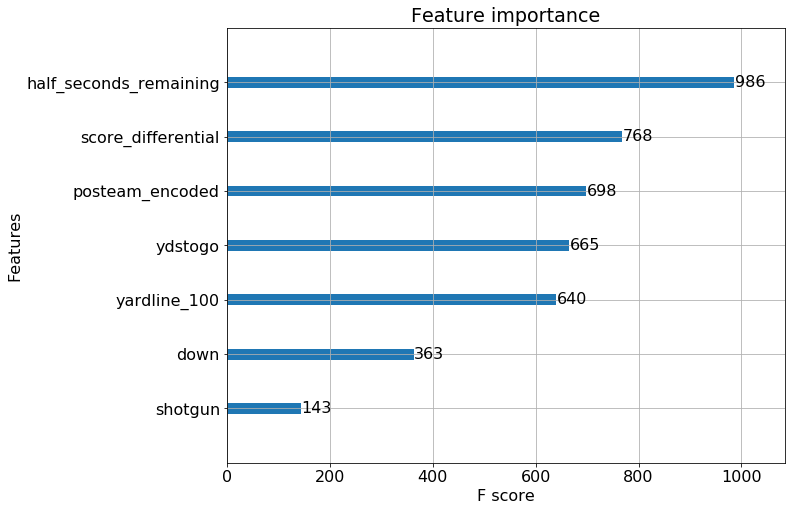

In [298]:
import matplotlib
fig, ax = plt.subplots(figsize = (10,8))
xgb.plot_importance(xgb_classifier,ax=ax)
matplotlib.rcParams.update({'font.size': 22})

### Predicting the play type AND direction selection at any time (league wide)

In [300]:
df_play_dir['play_call'] = df_play_dir[['play_type', 'direction']].apply(lambda x: ' '.join(x), axis = 1) 

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [302]:
le = LabelEncoder()
df_play_dir['play_call_encoded'] = le.fit_transform(df_play_dir['play_call'])

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [303]:
df_play_dir['play_call_encoded'].value_counts()

2    70613
0    61516
5    46838
3    46341
1    39294
4    35617
Name: play_call_encoded, dtype: int64

In [305]:
df_plays_15_17 = df_play_dir[df_play_dir['game_date'].str.contains('2015|2016|2017')]
df_plays_18 = df_play_dir[df_play_dir['game_date'].str.contains('2018')]

X_train = df_plays_15_17[['yardline_100', 'half_seconds_remaining','down','ydstogo','score_differential','posteam_encoded','shotgun']]
y_train = df_plays_15_17['play_call_encoded']

In [306]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(colsample_bytree=0.6,learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=3,n_estimators=300,subsample=0.7,)
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [307]:
X_test  = df_plays_18[['yardline_100', 'half_seconds_remaining','down','ydstogo','score_differential','posteam_encoded','shotgun']]
y_actual = df_plays_18['play_call_encoded']
y_pred = xgb_classifier.predict(X_test)

print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

           0       0.28      0.25      0.26      5824
           1       0.27      0.02      0.03      3764
           2       0.28      0.52      0.37      6462
           3       0.25      0.26      0.26      4077
           4       0.37      0.15      0.21      3549
           5       0.25      0.29      0.27      4005

    accuracy                           0.28     27681
   macro avg       0.28      0.25      0.23     27681
weighted avg       0.28      0.28      0.25     27681

